# Libraries 

In [93]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from collections import Counter
from scipy.stats import ttest_ind, f_oneway, pearsonr, chi2_contingency

%matplotlib inline

# Load Data

In [72]:
with open("data/watch-history.json", "r", encoding="utf-8") as file:
    raw_data = json.load(file)

df = pd.DataFrame(raw_data)
df.head()

,header,title,titleUrl,subtitles,time,products,activityControls,description,details
0,YouTube,Watched Now THAT’S a Gallop Riff | Dave Davids...,https://www.youtube.com/watch?v=2vfzN-vAX8E,"[{'name': 'Garza Podcast', 'url': 'https://www...",2025-11-30T15:40:59.898Z,[YouTube],[YouTube watch history],NaN,NaN
1,YouTube,Watched Vazgeçemeyeceğin Lime Aromasına Hazır ...,https://www.youtube.com/watch?v=BIHwd_9ohcw,"[{'name': 'Doritos Türkiye', 'url': 'https://w...",2025-11-30T14:35:29.556Z,[YouTube],[YouTube watch history],NaN,NaN
2,YouTube,Watched Exploratory Data Analysis,https://www.youtube.com/watch?v=QiqZliDXCCg,"[{'name': 'IBM Technology', 'url': 'https://ww...",2025-11-30T13:30:58.974Z,[YouTube],[YouTube watch history],NaN,NaN
3,YouTube,Watched Best Wayland Window Managers 2025: Hyp...,https://www.youtube.com/watch?v=Q827qLzXGfc,"[{'name': 'TheBlackDon', 'url': 'https://www.y...",2025-11-30T12:58:22.320Z,[YouTube],[YouTube watch history],NaN,NaN
4,YouTube,Watched What Your Linux Distro Says About You,https://www.youtube.com/watch?v=ImtoYNt8lFw,"[{'name': 'The Linux Cast', 'url': 'https://ww...",2025-11-30T12:22:41.285Z,[YouTube],[YouTube watch history],NaN,NaN


# Data Cleaning

In [73]:
# get channel name
df["channel"] = df["subtitles"].apply(
    lambda x: x[0]["name"] if isinstance(x, list) and len(x) > 0 else None
)

# convert time to datetime
df['time'] = pd.to_datetime(df['time'], format='ISO8601')

# remove the 'Watched' prefix
df["title"] = df["title"].apply(lambda x: x.removeprefix("Watched "))

# seperate time for easier processing
df["year"] = df["time"].dt.year
df["month"] = df["time"].dt.month
df["day"] = df["time"].dt.day
df["hour"] = df["time"].dt.hour
df['month_name'] = df['time'].dt.month_name()
df["day_name"] = df["time"].dt.day_name()
df["date"] = df["time"].dt.date


df = df.dropna(subset=["time"]).sort_values("time").reset_index(drop=True)
df.head()

,header,title,titleUrl,subtitles,time,products,activityControls,description,details,channel,year,month,day,hour,month_name,day_name,date
0,YouTube,Twitch Hates Them: The Top 10 Banned Streamers,https://www.youtube.com/watch?v=mVB-psZOX2g,"[{'name': 'theScore esports', 'url': 'https://...",2021-06-03 11:57:44.719000+00:00,[YouTube],[YouTube watch history],NaN,NaN,theScore esports,2021,6,3,11,June,Thursday,2021-06-03
1,YouTube,Nathan Evans - Wellerman (Sea Shanty),https://www.youtube.com/watch?v=qP-7GNoDJ5c,"[{'name': 'NathanEvansVEVO', 'url': 'https://w...",2021-06-03 12:08:18.626000+00:00,[YouTube],[YouTube watch history],NaN,NaN,NathanEvansVEVO,2021,6,3,12,June,Thursday,2021-06-03
2,YouTube,Wellerman,https://www.youtube.com/watch?v=UNVFEt5vkWc,"[{'name': 'The Longest Johns - Topic', 'url': ...",2021-06-03 12:08:53.024000+00:00,[YouTube],[YouTube watch history],NaN,NaN,The Longest Johns - Topic,2021,6,3,12,June,Thursday,2021-06-03
3,YouTube,WELLERMAN (Sea Shanty) METAL COVER by Jonathan...,https://www.youtube.com/watch?v=Oqr9Iq-LEVY,"[{'name': 'Jonathan Young', 'url': 'https://ww...",2021-06-03 12:10:32.001000+00:00,[YouTube],[YouTube watch history],NaN,NaN,Jonathan Young,2021,6,3,12,June,Thursday,2021-06-03
4,YouTube,Wellerman (Sea Shanty) but it's Pirate Metal [...,https://www.youtube.com/watch?v=tiWX0x1wk68,"[{'name': 'LittleVMills', 'url': 'https://www....",2021-06-03 12:11:09.990000+00:00,[YouTube],[YouTube watch history],NaN,NaN,LittleVMills,2021,6,3,12,June,Thursday,2021-06-03


# General Observations

In [74]:
print("Total videos watched:", len(df))
print("Unique channels:", df["channel"].nunique())
print("Time range:", df["date"].min(), "to ", df["date"].max())
print("Number of days with videos watched:", df["date"].nunique())
print("Most active day:", df["date"].value_counts().idxmax())
print("Videos on that day:", df["date"].value_counts().max())

Total videos watched: 42453
Unique channels: 13654
Time range: 2021-06-03 to  2025-11-30
Number of days with videos watched: 1573
Most active day: 2024-02-07
Videos on that day: 286


# EDA

## Videos watched per hour

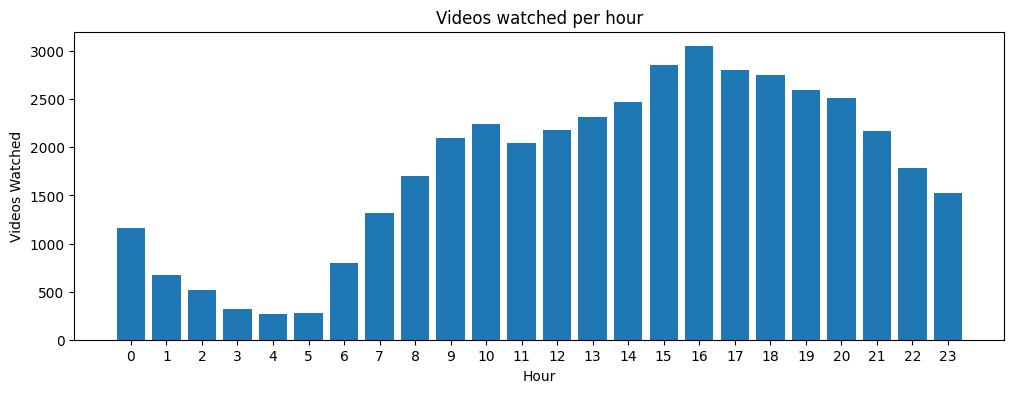

In [128]:
hourly = df["hour"].value_counts().sort_index()

plt.figure(figsize=(12,4))
plt.bar(hourly.index, hourly.values)
plt.xticks(range(0,24))
plt.xlabel("Hour")
plt.ylabel("Videos Watched")
plt.title("Videos watched per hour")
plt.savefig('perhour.png')
plt.show()

## Videos watched per day

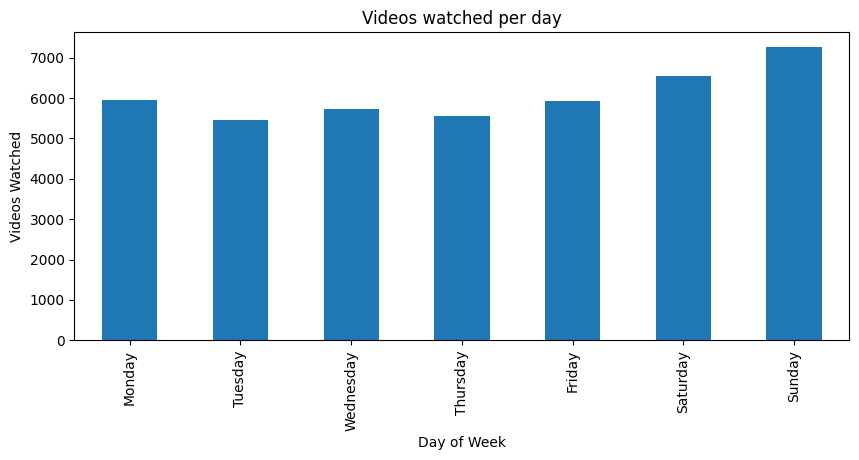

In [127]:
days = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
daily = df["day_name"].value_counts().reindex(days)

plt.figure(figsize=(10,4))
daily.plot(kind="bar")
plt.xlabel("Day of Week")
plt.ylabel("Videos Watched")
plt.title("Videos watched per day")
plt.savefig('perday.png')
plt.show()

## Youtube Usage (Day vs Hour)

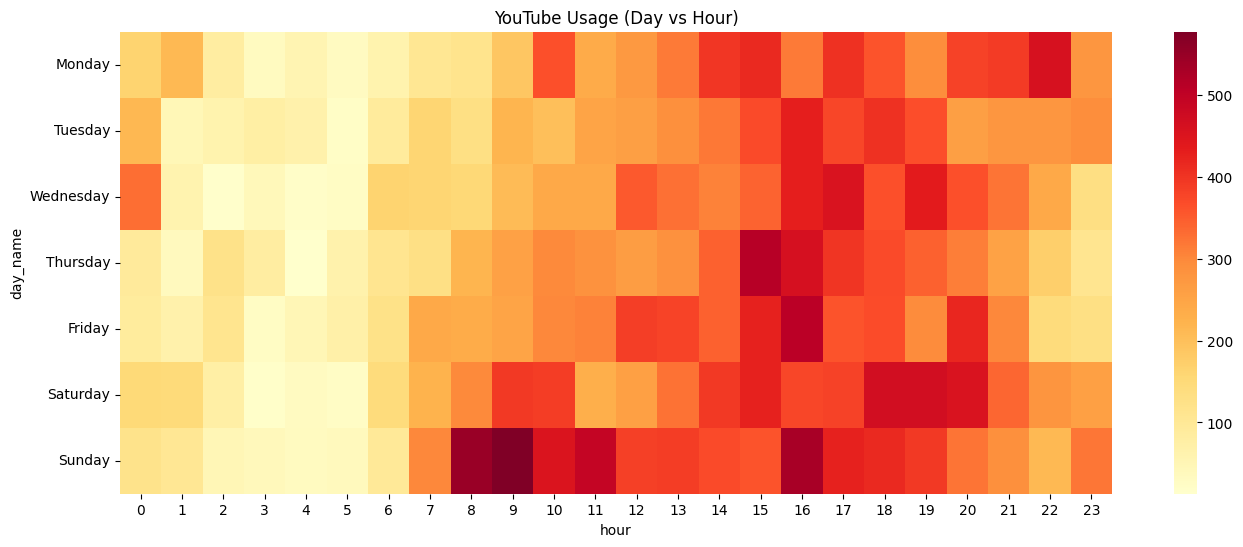

In [126]:
pivot = df.pivot_table(index="day_name", columns="hour", values="title", aggfunc="count")

plt.figure(figsize=(16,6))
sns.heatmap(pivot.reindex(days), cmap="YlOrRd")
plt.title("YouTube Usage (Day vs Hour)")
plt.savefig('heatmap.png')
plt.show()

## Top Channels

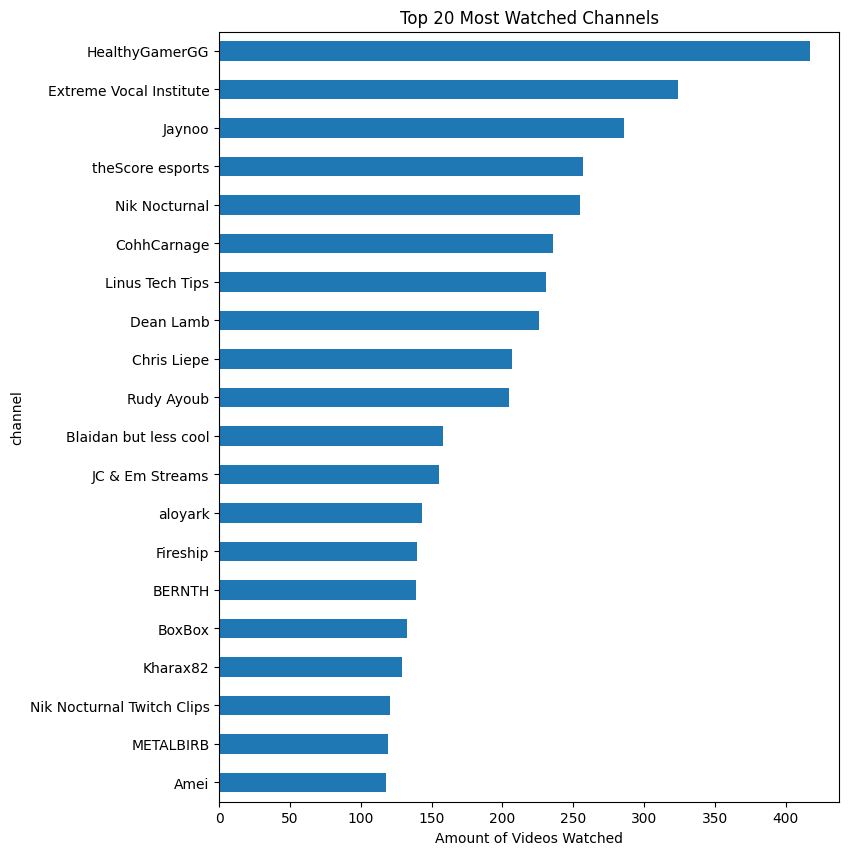

In [125]:
top_channels = df["channel"].value_counts().head(20)

plt.figure(figsize=(8,10))
top_channels.sort_values().plot(kind="barh")
plt.title("Top 20 Most Watched Channels")
plt.xlabel("Amount of Videos Watched")
plt.savefig('mostwatchedchannels.png')
plt.show()

## Cleaning of video titles
Manually removed most non-contnet related words

In [79]:
from collections import Counter
import re

ignored_words = set(
    ['watched',
     'video', 
     'youtube',
     'shorts', 
     'the', 
     'be',
     'to', 
     'of', 
     'in', 
     'and', 
     'a', 
     'in',
     'that',
     'have',
     'I',
     'it', 
     'for', 
     'not',
     'on', 
     'with', 
     'as',
     'my', 
     'at', 
     'is', 
     'this',
     'your',
     'what',
     'from',
     'when',
    ])

def clean_title(t):
    t = re.sub(r"[^a-zA-Z ]", "", t)
    t = t.lower()
    return t.split()

all_words = []
for title in df["title"].dropna():
    all_words.extend(clean_title(title))

filtered_words = [w for w in all_words if w not in ignored_words and len(w) > 3]

common = Counter(filtered_words).most_common(30)
words_df = pd.DataFrame(common, columns=["word", "count"])
words_df

,word,count
0,guitar,1663
1,nier,1071
2,cover,1055
3,live,1049
4,minecraft,988
5,metal,893
6,automata,860
7,part,842
8,tutorial,680
9,music,680


## Most common words in titles

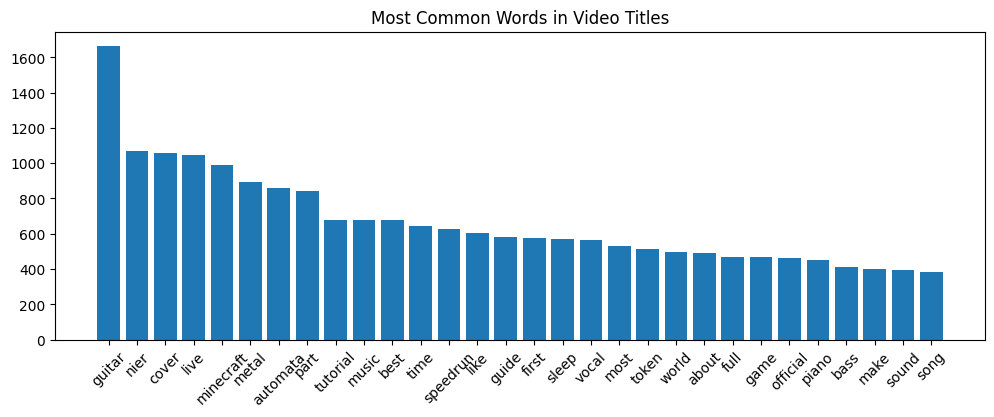

In [124]:
plt.figure(figsize=(12,4))
plt.bar(words_df["word"], words_df["count"])
plt.xticks(rotation=45)
plt.title("Most Common Words in Video Titles")
plt.savefig('mostcommonwords.png')
plt.show()

## Video Categorization

In [81]:
def classify_video(title):
    title = str(title).lower()
    
    categories = {
        'Programming': [
            'python', 'java', 'c++', 'javascript', 'html', 'css', 'react', 'node', 
            'algorithm', 'leetcode', 'data structure', 'system design', 'backend', 
            'frontend', 'full stack', 'web dev', 'api', 'git', 'github', 'docker', 
            'sql', 'database', 'neovim', 'vim', 'emacs', 'ide', 'flutter', 'dart',
            'visual studio', 'debug', 'code', 'programming', 'developer', 'vscode'
        ],
        'Data Science': [
            'machine learning', 'deep learning', 'neural network', 'ai', 'gpt', 'llm', 
            'pandas', 'numpy', 'matplotlib', 'seaborn', 'scikit', 'tensorflow', 
            'pytorch', 'data analysis', 'visualization', 'dataset', 'statistics', 
            'probability', 'regression', 'clustering'
        ],
        'Linux': [
            'linux', 'ubuntu', 'arch', 'debian', 'fedora', 'kali', 'mint', 'pop os', 
            'bash', 'shell', 'terminal', 'zsh', 'command line', 'sysadmin', 'server', 
            'ssh', 'wsl', 'distro', 'desktop environment', 'gnome', 'kde', 'xfce', 
            'i3', 'sway', 'hyprland', 'wayland', 'window manager', 'rice', 'unix'
        ],
        'Education': [
            'calculus', 'algebra', 'linear algebra', 'differential equations', 
            'physics', 'chemistry', 'biology', 'math', 'lecture', 'professor', 
            'course', 'exam', 'study', 'student', 'university', 'college', 
            'sabanci', 'derivatives', 'integrals', 'proof', 'ayt', 'tyt', 'matematik',
            'biyoloji', 'kimya', 'fizik', 'edebiyat', 'çözüm', 'çözümü', 'çözümleri',
        ],
        'Gaming': [
            'gameplay', 'walkthrough', 'playthrough', 'part', 'ep', 'episode', 
            'boss', 'ending', 'cutscene', 'trailer', 'teaser', 'review', 'ign', 
            'gamespot', 'steam', 'twitch', 'stream', 'esports', 'speedrun', 
            'minecraft','valorant', 'csgo', 'league of legends', 'PUBG'
            'dota', 'overwatch', 'elden ring', 'souls', 'sekiro', 'gtnh', 'gt:nh',
            'gregtech', 'new horizions', 'nier', 'automata', 'replicant', 'final fantasy',
            'rpg', 'fps', 'strategy', 'nintendo', 'playstation', 'xbox', 'hitman', 'titanfall',
            'game', 'any%', 'glitch', 'counter strike'
        ],
        'Music': [
            'official video', 'lyrics', 'feat.', 'cover', 'full album', 'visualizer', 
            'mv', 'music video', 'guitar', 'riff', 'solo', 'drum', 'bass', 'tab', 
            'lesson', 'shred', 'metal', 'rock', 'djent', 'prog', 'polyphia', 
            'periphery', 'animals as leaders', 'live', 'concert', 
            'audio', 'remix', 'soundtrack', 'ost', 'vocal', 'musical', 'avenged sevenfold',
            'backing track', 'jam track',
        ],
        'Tech and Hardware': [
            'review', 'unboxing', 'comparison', 'benchmark', 'pc build', 'setup', 
            'keyboard', 'mouse', 'monitor', 'laptop', 'thinkpad', 'macbook', 
            'iphone', 'android', 'samsung', 'apple', 'nvidia', 'amd', 'intel', 
            'cpu', 'gpu', 'graphics card', 'tech', 'gadget', 'pc', 'vr', 'qualcomm',
            'snapdragon', 'dell', 'lenovo', 'msi', 'razer', 'logitech', 'corsair',
            'noctua', 'nzxt', 'tech', 'hardware', 
        ],
        'Entertainment': [
            'vlog', 'day in the life', 'challenge', 'prank', 'react', 'reaction', 
            'funny', 'meme', 'compilation', 'shorts', 'tiktok', 'vine', 'fail', 
            'win', 'story time', 'mrbeast', 'pewdiepie', 'short', 
        ],
        'News and Podcast': [
            'news', 'update', 'politics', 'debate', 'interview', 'podcast', 
            'lex fridman', 'analysis', 'documentary', 'essay', 'video essay',
            'critique'
        ]
    }

    for category, keywords in categories.items():
        for keyword in keywords:
            if keyword in title:
                return category
                
    return 'Other'

df["category"] = df["title"].apply(classify_video)
df["category"].value_counts()

category
Other                17530
Gaming                7453
Music                 5608
Programming           4119
Data Science          2677
Entertainment         2058
Education             1108
Linux                  926
Tech and Hardware      768
News and Podcast       206
Name: count, dtype: int64

category
Other                17530
Gaming                7453
Music                 5608
Programming           4119
Data Science          2677
Entertainment         2058
Education             1108
Linux                  926
Tech and Hardware      768
News and Podcast       206
Name: count, dtype: int64


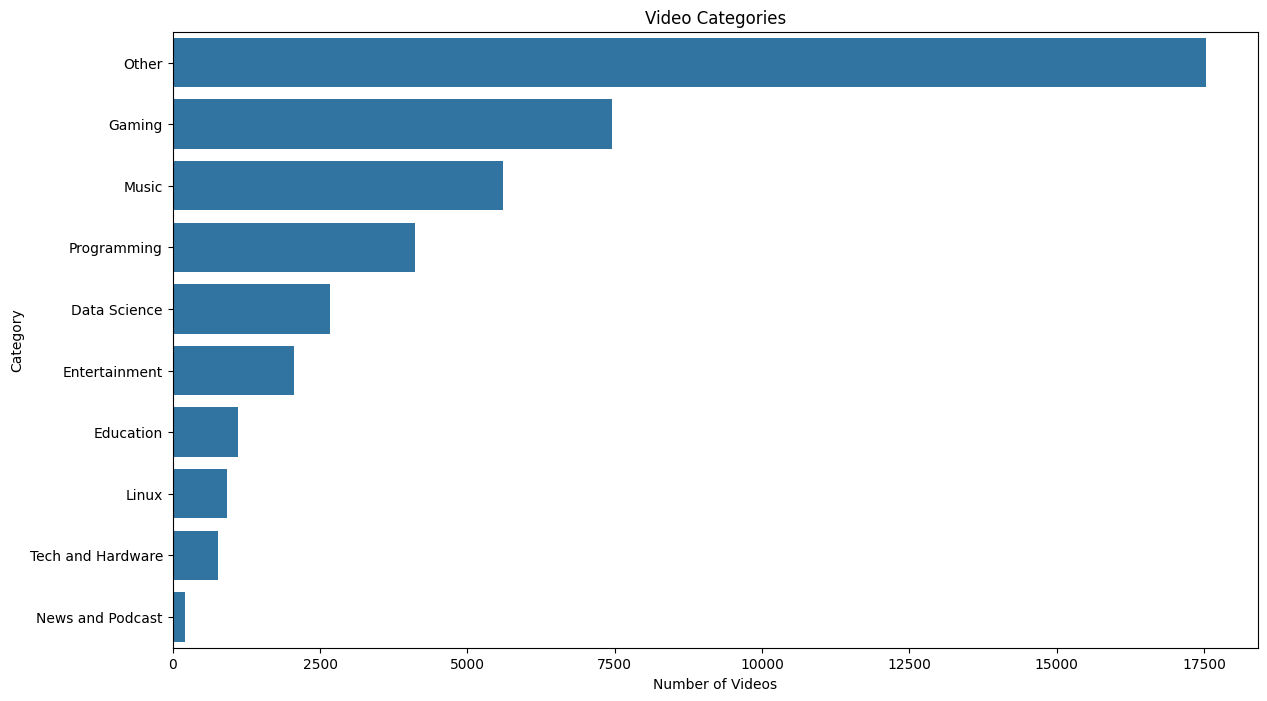

In [123]:
df["category"] = df["title"].apply(classify_video)

# Check the new stats
print(df['category'].value_counts())

# Visualize the improvement
plt.figure(figsize=(14, 8))
order = df['category'].value_counts().index
sns.countplot(y='category', data=df, order=order)
plt.title('Video Categories')
plt.xlabel('Number of Videos')
plt.ylabel('Category')
plt.savefig('categories.png')
plt.show()

# Hypothesis Testing

## Daytime Usage vs Nighttime Usage

In [117]:
# define night (18:00 - 05:00) vs Day (06:00 - 17:00)
is_night = (df['hour'] >= 18) | (df['hour'] <= 5)

# get dates to handle days with no videos watched
all_dates = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D')

# calculate daily videos watched
day_daily = df[~is_night].groupby('date').size().reindex(all_dates, fill_value=0)
night_daily = df[is_night].groupby('date').size().reindex(all_dates, fill_value=0)

# is daytime > nighttime
t_stat, p_val = ttest_ind(day_daily, night_daily, alternative='greater')

print(f"Daytime Mean (videos/day):   {day_daily.mean():.2f}")
print(f"Nighttime Mean (videos/day): {night_daily.mean():.2f}")
print(f"p-value: {p_val}")

if p_val < 0.05:
    print("Reject H0, p-value is significant")
else:
    print("Don't reject H0, p-value is not significant")

Daytime Mean (videos/day):   15.76
Nighttime Mean (videos/day): 10.10
p-value: 2.5113185059602055e-14
Reject H0, p-value is significant


## Exam period usage

In [118]:
# may, june, november, december
exam_months = [12, 5, 6, 11] 
df['is_exam_period'] = df['month'].isin(exam_months)

exam_daily = df[df['is_exam_period']].groupby('date').size().reindex(all_dates, fill_value=0)
no_exam_daily = df[~df['is_exam_period']].groupby('date').size().reindex(all_dates, fill_value=0)

t_stat, p_val = ttest_ind(exam_daily, no_exam_daily) # Two-sided test for "change"
print(f"Exam Daily Mean: {exam_daily.mean():.2f}, Non-Exam Mean: {no_exam_daily.mean():.2f}")
print(f"p-value: {p_val:.30f}")
print("Result:", "Significant Change (Reject H0)" if p_val < 0.05 else "No Significant Change")
print()

Exam Daily Mean: 7.70, Non-Exam Mean: 18.15
p-value: 0.000000000000000000000000000024
Result: Significant Change (Reject H0)



## Channel Diversity change

In [119]:
monthly_diversity = df.groupby(['year', 'month'])['channel'].nunique().reset_index()

start_year = df['year'].min()
end_year = df['year'].max()

diversity_start = monthly_diversity[monthly_diversity['year'] == start_year]['channel']
diversity_end = monthly_diversity[monthly_diversity['year'] == end_year]['channel']

if start_year == end_year:
    print(f"Data only covers {start_year}. Cannot compare years.")
else:
    t_stat, p_val = ttest_ind(diversity_start, diversity_end)
    print(f"Mean Unique Channels ({start_year}): {diversity_start.mean():.1f}")
    print(f"Mean Unique Channels ({end_year}): {diversity_end.mean():.1f}")
    print(f"p-value: {p_val:.4f}")
    print("Result:", "Significant Change (Reject H0)" if p_val < 0.05 else "No Change")
print()

Mean Unique Channels (2021): 246.7
Mean Unique Channels (2025): 373.5
p-value: 0.1577
Result: No Change



## Music at Night

In [120]:
# get music related content
music_df = df[df['category'] == 'Music']

# how many are day or night
music_night_daily = music_df[music_df['is_night']].groupby('date').size().reindex(all_dates, fill_value=0)
music_day_daily = music_df[~music_df['is_night']].groupby('date').size().reindex(all_dates, fill_value=0)

t_stat, p_val = ttest_ind(music_night_daily, music_day_daily, alternative='greater')
print(f"Night Music Mean: {music_night_daily.mean():.2f}, Day Music Mean: {music_day_daily.mean():.2f}")
print(f"p-value: {p_val:.4f}")
print("I listen to more music at night (Reject H0)" if p_val < 0.05 else "p-value not significant")
print()

Night Music Mean: 1.32, Day Music Mean: 2.09
p-value: 1.0000
p-value not significant



## Attention-Span Decrease

In [121]:
df = df.sort_values('time')

# time difference between videos
df['time_diff_seconds'] = df['time'].diff().dt.total_seconds()

# if two videos are watched within the same minute, they are considered
# rapid switch or short attention span videos.
df['is_rapid_switch'] = (df['time_diff_seconds'] < 60) & (df['time_diff_seconds'] >= 0)

# rate of rapid switch
monthly_rapid = df.groupby(['year', 'month'])['is_rapid_switch'].mean().reset_index()
monthly_rapid['time_index'] = np.arange(len(monthly_rapid))

# 5. Check if we have enough variance
if monthly_rapid['is_rapid_switch'].std() == 0:
    print("Usage is constant. No trend detected.")
else:
    # 6. Run Pearson Correlation
    corr, p_val = pearsonr(monthly_rapid['time_index'], monthly_rapid['is_rapid_switch'])

    print(f"Correlation: {corr:.4f}")
    print(f"p-value: {p_val:.10f}")

    if p_val < 0.05:
        if corr > 0:
            print("My attention span has decreased :( (increase in rapid-switching) (Reject H0)")
        else:
            print("my attention span has not decreased yay :), (i am not giving into brain rot)")
    else:
        print("no change in attention span")

Correlation: 0.5324
p-value: 0.0000341465
My attention span has decreased :( (increase in rapid-switching) (Reject H0)


## Change in Interests

In [122]:
# ignore the 'other' category
df_clean = df[df['category'] != 'Other']

# top category for first and last year
top_cat_start = df_clean[df_clean['year'] == df_clean['year'].min()]['category'].mode()[0]
top_cat_end   = df_clean[df_clean['year'] == df_clean['year'].max()]['category'].mode()[0]

print(f"Top Category {df_clean['year'].min()}: {top_cat_start}")
print(f"Top Category {df_clean['year'].max()}: {top_cat_end}")

# 3. Conclusion
if top_cat_start != top_cat_end:
    print("Most dominant category has changed from 2021 to 2025")
    print("Reject H0")
else:
    print("Most dominant category has NOT changed from 2021 to 2025")
    print("Fail to reject H0")

Top Category 2021: Gaming
Top Category 2025: Gaming
Most dominant category has NOT changed from 2021 to 2025
Fail to reject H0
